In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy.linalg import solve
from scipy.stats import invgamma, t, multivariate_t

import matplotlib.pyplot as plt

Data taken from the book *Introduction to Linear Regression Analysis. Montgomery, Peck and Vining. Fifth Edition.* The data correspond to the problem 2.7.

The purity of oxygen produced by a fractional distillation process is thought to be related to the percentage of hydrocarbons in the main condensor of the processing unit. Twenty samples are taken.

In [2]:
ALPHA = 0.05

In [3]:
Dat = pd.read_csv('Data/PurezaCondensador.csv')

Since a priori we have no information about the parameters of the regression, we take a noninfomrative prior distribution.

We now calculate the punctual estimators for $\beta$ and $\sigma^2$.

In [4]:
X = sm.add_constant(Dat['Hydrocarbon (%)'])
Y = Dat['Purity (%)']

n, p = X.shape

XTX_1 = solve(X.T @ X, np.eye(p))

HatBeta = solve(X.T @ X, X.T @ Y)
SSR = (Y - X @ HatBeta).T @ (Y - X @ HatBeta)
HatSigma2 = SSR / (n-p)

We get an interval of $1-\alpha$ posterior probability for $\beta$ and $\sigma$. We have set $\alpha=0.05$.

In [5]:
IntervalBeta0 = t.ppf([ALPHA/2, 1-ALPHA/2], df=n-p, loc=HatBeta[0], scale=np.sqrt(HatSigma2*XTX_1[0,0]))
IntervalBeta1 = t.ppf([ALPHA/2, 1-ALPHA/2], df=n-p, loc=HatBeta[1], scale=np.sqrt(HatSigma2*XTX_1[1,1]))

IntervalSigma2 = invgamma.ppf([ALPHA/2, 1-ALPHA/2], a=(n-p)/2, scale=SSR/2)

We plot the posterior density for $\beta$, select the punctual estimator and show the confidence interval for $\beta_0$ and $\beta_1$.

Text(0, 0.5, '$\\beta_1$')

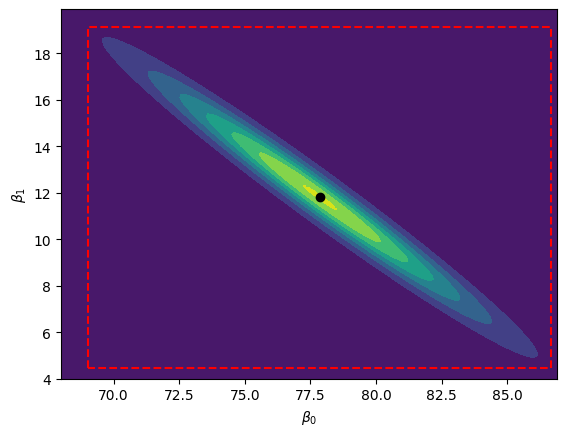

In [6]:
rv = multivariate_t(df=n-p, loc=HatBeta, shape=HatSigma2*XTX_1)

x, y = np.mgrid[68:87:0.1, 4:20:0.1]
pos = np.dstack((x, y))

plt.contourf(x, y, rv.pdf(pos))
plt.scatter(x=HatBeta[0], y=HatBeta[1], color='k')

plt.plot(
    [
        IntervalBeta0[0]
        , IntervalBeta0[0]
        , IntervalBeta0[1]
        , IntervalBeta0[1]
        , IntervalBeta0[0]
    ]
    , [
        IntervalBeta1[0]
        , IntervalBeta1[1]
        , IntervalBeta1[1]
        , IntervalBeta1[0]
        , IntervalBeta1[0]
    ]
    , color='r'
    , ls='--'
    )

plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$')

We plot the posterior density for $\sigma^2$, select the punctual estimator and show its confidence interval.

Text(0.5, 0, '$\\sigma^2$')

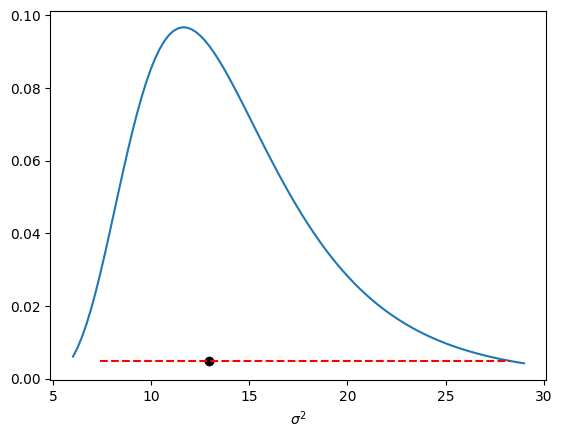

In [7]:
YPos = invgamma.pdf(IntervalSigma2[1], a=(n-p)/2, scale=SSR/2)

x = np.linspace(6,29,100)
plt.plot(x, invgamma.pdf(x, a=(n-p)/2, scale=SSR/2))
plt.scatter(x=HatSigma2, y=YPos, color='k')
plt.plot(IntervalSigma2, [YPos]*2, color='r', ls='--')
plt.xlabel(r'$\sigma^2$')

We create a scatterplot of the points and show the best fitted line, as well as a confidence interval for the mean and a prediction interval for the observations.

In [8]:
x = np.linspace(Dat['Hydrocarbon (%)'].min(), Dat['Hydrocarbon (%)'].max())
X0 = sm.add_constant(x)

mu0 = X0 @ HatBeta
scale_conf = np.sqrt(HatSigma2 * np.diag(X0 @ XTX_1 @ X0.T))
scale_pred = np.sqrt(HatSigma2 * (1+np.diag(X0 @ XTX_1 @ X0.T)))

ConfIntervals, PredIntervals = [], []

for j in range(len(mu0)):
    ConfIntervals.append(t.ppf([ALPHA/2, 1-ALPHA/2], df=n-p, loc=mu0[j], scale=scale_conf[j]))
    PredIntervals.append(t.ppf([ALPHA/2, 1-ALPHA/2], df=n-p, loc=mu0[j], scale=scale_pred[j]))

ConfIntervals = np.array(ConfIntervals).T
PredIntervals = np.array(PredIntervals).T

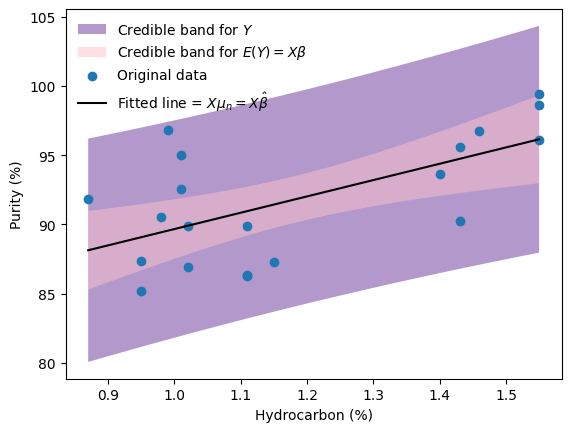

In [11]:
plt.fill_between(x, PredIntervals[0], PredIntervals[1], facecolor='rebeccapurple', alpha=0.5, label=r"Credible band for $Y$")
plt.fill_between(x, ConfIntervals[0], ConfIntervals[1], facecolor='pink', alpha=0.5, label=r"Credible band for $E(Y)=X\beta$")
plt.scatter(Dat['Hydrocarbon (%)'], Dat['Purity (%)'], label='Original data')
plt.plot(x, mu0, color='k', label=r'Fitted line = $X\mu_n = X\hat\beta$')

plt.xlabel('Hydrocarbon (%)')
plt.ylabel('Purity (%)')

plt.legend(loc='upper left', frameon=False)